### List of Libraries

In [69]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.parametrizations import spectral_norm
import random

### Hyper Parameters

In [70]:
BATCH_SIZE = 64
HIDDEN_FEATURES = 32
LR = 1e-4
ALPHA = 0.001
BETA1 = 0.0
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading Dataset

In [71]:
def get_dataloaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


train_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE)


### Shape and Scale of Each Image

#### each image is repreasented with a tensor with dimensions of (1,28,28) and is scaled between [0,1], an example is provided below

In [72]:
for batch in train_loader:
    images, _ = batch
    image = images[0]
    print(image.shape)
    print(f"image min is {image.min()}")
    print(f"image max is {image.max()}")
    break

torch.Size([1, 28, 28])
image min is 0.0
image max is 0.9960784316062927


### Visualizing Dataset

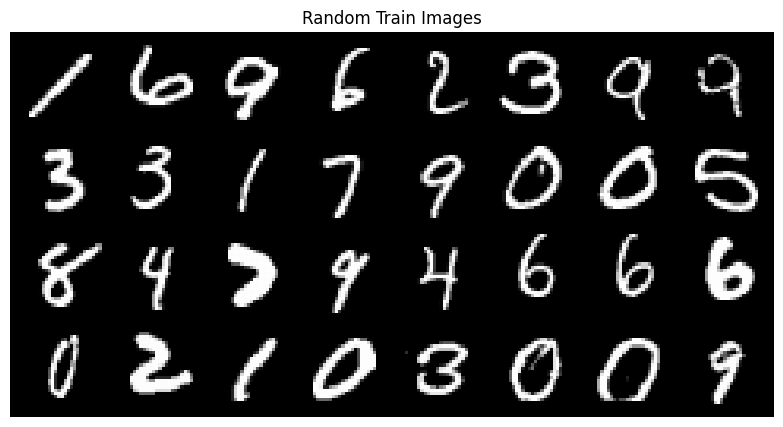

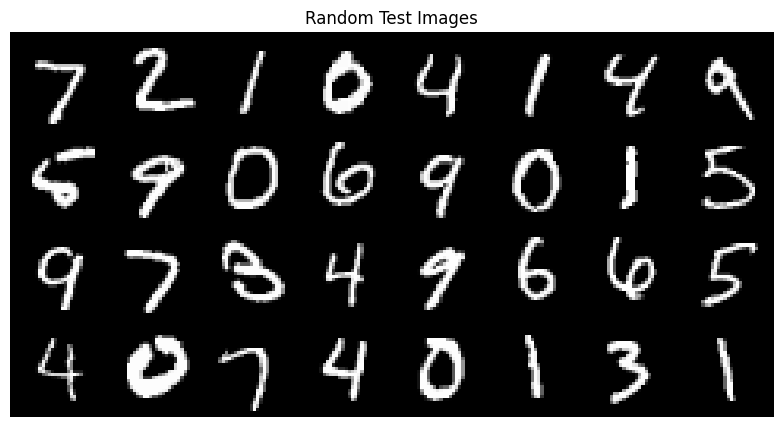

In [73]:
def show_batch_images(dataloader, title, num_images):
    for batch in dataloader:
        images, _ = batch
        images = images[:num_images]
        break
    
    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_batch_images(train_loader, "Random Train Images", 32)

show_batch_images(test_loader, "Random Test Images", 32)

### Model Architecture

### images: 28*28 -> 14x14 (Downsample) -> 14x14 (Refine) -> 7x7 (Downsample) -> 7x7 (Refine) -> Flattern

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EnergyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.AdaptiveAvgPool2d(output_size=1),
            
            nn.Flatten(),
            
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

# langevin sampling

Our goal is to transform an initial noisy input into a realistic sample by navigating the energy landscape learned by the model.

## $$x_{t+1} = x_t - \frac{\eta}{2} \nabla_x E(x_t) + \sqrt{\eta} \epsilon$$

Where:

$x_t$: The image at step $t$.

$\eta$: The step size (learning rate for the sampling).

$\nabla_x E_\theta(x_t)$: The gradient of the energy function with respect to the input image.

$\epsilon \sim \mathcal{N}(0, \sigma^2)$: 


Gaussian noise added at each step.

In [75]:
def langevin_sampling(model, x, steps=60, step_size=10.0):
    was_training = model.training
    if was_training:
        model.eval()
    
    for p in model.parameters():
        p.requires_grad = False
        
    x.requires_grad_(True)
    
    had_gradients_enabled = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
            
    for _ in range(steps):
        x.data.add_(torch.randn_like(x) * 0.02)
        x.data.clamp_(0.0, 1.0)
    
        energy = model(x)
        grads = torch.autograd.grad(energy.sum(), x)[0]
        grads = torch.clamp(grads, -0.03, 0.03)
        
        x.data.add_(-step_size * grads)
        x.data.clamp_(0.0, 1.0)

    for parameter in model.parameters():
        parameter.requires_grad = True
    if was_training:
        model.train()
    torch.set_grad_enabled(had_gradients_enabled)

    return x


$$
\mathcal{L}_{data} = \frac{1}{B} \sum_{i=1}^{B} E_{real}^{(i)} - \frac{1}{B} \sum_{i=1}^{B} E_{fake}^{(i)}
$$

$$
\mathcal{L}_{reg} = \lambda \left( \frac{1}{B} \sum_{i=1}^{B} (E_{real}^{(i)})^2 + \frac{1}{B} \sum_{i=1}^{B} (E_{fake}^{(i)})^2 \right)
$$

$$
\mathcal{L} = \mathcal{L}_{data} + \mathcal{L}_{reg}
$$

**Where:**
* $B$: Batch size

# Training Loop

Epoch [0] Batch [0] Loss: 0.0015
Epoch [0] Batch [100] Loss: -0.3224
Epoch [0] Batch [200] Loss: -0.2246
Epoch [0] Batch [300] Loss: -0.0621
Epoch [0] Batch [400] Loss: -0.1567
Epoch [0] Batch [500] Loss: 0.3712
Epoch [0] Batch [600] Loss: 0.0148
Epoch [0] Batch [700] Loss: -0.1195
Epoch [0] Batch [800] Loss: -0.5305
Epoch [0] Batch [900] Loss: -0.0588


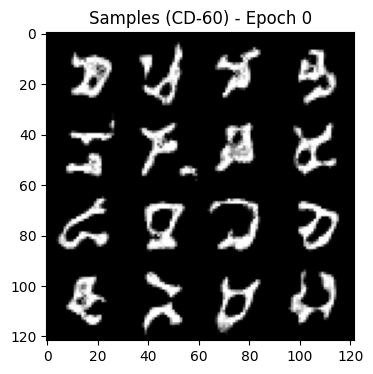

Epoch [1] Batch [0] Loss: 0.1038
Epoch [1] Batch [100] Loss: 0.2031
Epoch [1] Batch [200] Loss: 0.0399
Epoch [1] Batch [300] Loss: 0.2121
Epoch [1] Batch [400] Loss: 0.3091
Epoch [1] Batch [500] Loss: -0.0604
Epoch [1] Batch [600] Loss: -0.2007
Epoch [1] Batch [700] Loss: 0.1954
Epoch [1] Batch [800] Loss: 0.2424
Epoch [1] Batch [900] Loss: 0.0083


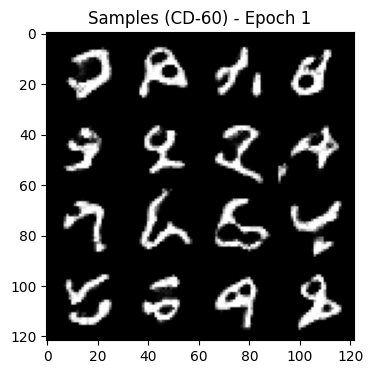

Epoch [2] Batch [0] Loss: 0.1937
Epoch [2] Batch [100] Loss: -0.0278
Epoch [2] Batch [200] Loss: -0.0358
Epoch [2] Batch [300] Loss: -0.0506
Epoch [2] Batch [400] Loss: -0.1479
Epoch [2] Batch [500] Loss: -0.1084
Epoch [2] Batch [600] Loss: -0.2910
Epoch [2] Batch [700] Loss: -0.0103
Epoch [2] Batch [800] Loss: -0.1893
Epoch [2] Batch [900] Loss: -0.1693


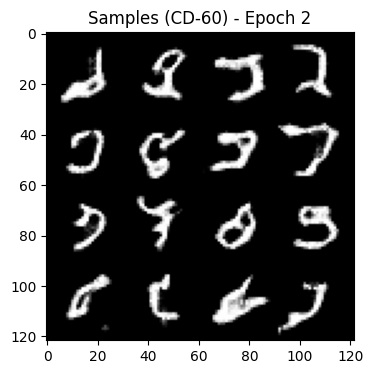

Epoch [3] Batch [0] Loss: 0.1668
Epoch [3] Batch [100] Loss: -0.1644
Epoch [3] Batch [200] Loss: -0.0122
Epoch [3] Batch [300] Loss: -0.0659
Epoch [3] Batch [400] Loss: 0.0110
Epoch [3] Batch [500] Loss: -0.1470
Epoch [3] Batch [600] Loss: 0.0868
Epoch [3] Batch [700] Loss: -0.2155
Epoch [3] Batch [800] Loss: 0.2150
Epoch [3] Batch [900] Loss: 0.0316


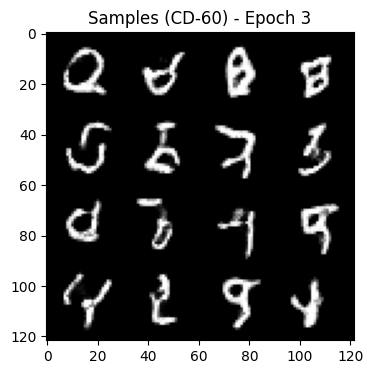

Epoch [4] Batch [0] Loss: -0.4334
Epoch [4] Batch [100] Loss: 0.0135
Epoch [4] Batch [200] Loss: -0.0312
Epoch [4] Batch [300] Loss: -0.2110
Epoch [4] Batch [400] Loss: 0.0394
Epoch [4] Batch [500] Loss: -0.1473
Epoch [4] Batch [600] Loss: -0.1287
Epoch [4] Batch [700] Loss: 0.1464
Epoch [4] Batch [800] Loss: -0.1337
Epoch [4] Batch [900] Loss: 0.0266


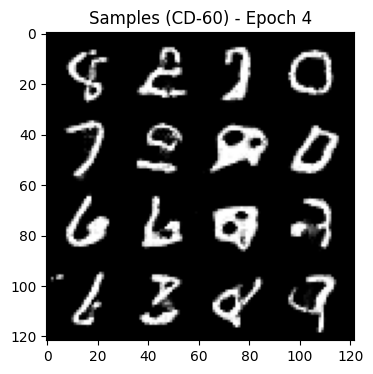

Epoch [5] Batch [0] Loss: 0.0599
Epoch [5] Batch [100] Loss: 0.2201
Epoch [5] Batch [200] Loss: -0.2594
Epoch [5] Batch [300] Loss: 0.5789
Epoch [5] Batch [400] Loss: -0.1895
Epoch [5] Batch [500] Loss: 0.0804
Epoch [5] Batch [600] Loss: 0.3298
Epoch [5] Batch [700] Loss: 0.0281
Epoch [5] Batch [800] Loss: -0.1945
Epoch [5] Batch [900] Loss: -0.0486


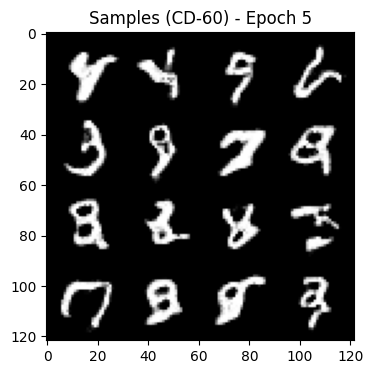

Epoch [6] Batch [0] Loss: 0.2518
Epoch [6] Batch [100] Loss: -0.0681
Epoch [6] Batch [200] Loss: 0.2748
Epoch [6] Batch [300] Loss: -0.0140
Epoch [6] Batch [400] Loss: -0.1572
Epoch [6] Batch [500] Loss: 0.1007
Epoch [6] Batch [600] Loss: -0.0333
Epoch [6] Batch [700] Loss: -0.2383
Epoch [6] Batch [800] Loss: 0.4193
Epoch [6] Batch [900] Loss: 0.0091


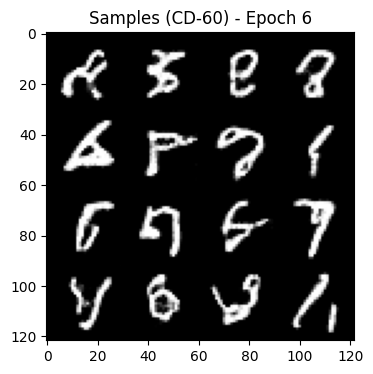

Epoch [7] Batch [0] Loss: -0.0324
Epoch [7] Batch [100] Loss: -0.0591
Epoch [7] Batch [200] Loss: -0.0602
Epoch [7] Batch [300] Loss: -0.0297
Epoch [7] Batch [400] Loss: 0.2135
Epoch [7] Batch [500] Loss: 0.1478
Epoch [7] Batch [600] Loss: -0.1445
Epoch [7] Batch [700] Loss: 0.2921
Epoch [7] Batch [800] Loss: -0.0571
Epoch [7] Batch [900] Loss: -0.1465


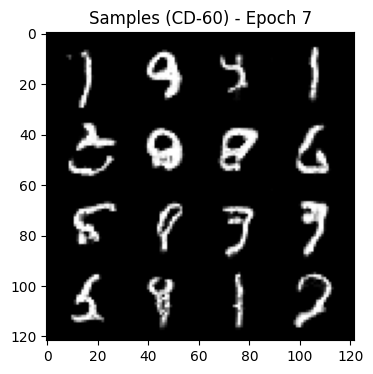

Epoch [8] Batch [0] Loss: -0.2294
Epoch [8] Batch [100] Loss: 0.2316
Epoch [8] Batch [200] Loss: -0.0617
Epoch [8] Batch [300] Loss: 0.2147
Epoch [8] Batch [400] Loss: 0.0457
Epoch [8] Batch [500] Loss: -0.1522
Epoch [8] Batch [600] Loss: -0.3146
Epoch [8] Batch [700] Loss: -0.1727
Epoch [8] Batch [800] Loss: 0.5202
Epoch [8] Batch [900] Loss: -0.0562


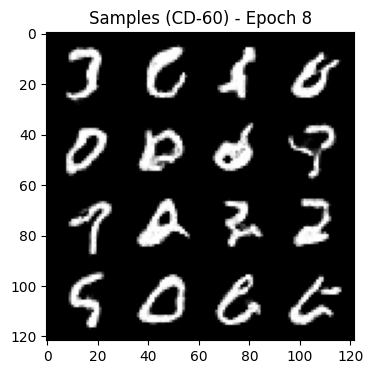

Epoch [9] Batch [0] Loss: -0.0101
Epoch [9] Batch [100] Loss: -0.1727
Epoch [9] Batch [200] Loss: -0.2935
Epoch [9] Batch [300] Loss: 0.0305
Epoch [9] Batch [400] Loss: -0.2192
Epoch [9] Batch [500] Loss: -0.1800
Epoch [9] Batch [600] Loss: -0.0399
Epoch [9] Batch [700] Loss: -0.1617
Epoch [9] Batch [800] Loss: 0.0408
Epoch [9] Batch [900] Loss: -0.1184


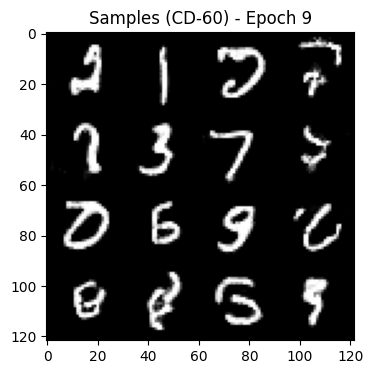

In [76]:
model = EnergyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(BETA1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

epoch_losses = []
epoch_real_energies = []
epoch_fake_energies = []

model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_real_energy = 0.0
    running_fake_energy = 0.0
    batch_count = 0
    
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        curr_batch_size = real_images.shape[0]
        
        fake_images = torch.rand((curr_batch_size, 1, 28, 28), device=device)        

        fake_images = langevin_sampling(model, fake_images, steps=60, step_size=10.0)
        
        optimizer.zero_grad()

        energy_real = model(real_images)
        energy_fake = model(fake_images)

        loss_data = energy_real.mean() - energy_fake.mean()
        loss_reg = ALPHA * (energy_real**2 + energy_fake**2).mean()
        loss = loss_data + loss_reg

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_real_energy += energy_real.mean().item()
        running_fake_energy += energy_fake.mean().item()
        batch_count += 1
        
        if i % 100 == 0:
            print(f"Epoch [{epoch}] Batch [{i}] Loss: {loss.item():.4f}")

    scheduler.step()
    
    avg_loss = running_loss / batch_count
    epoch_losses.append(avg_loss)
    epoch_real_energies.append(running_real_energy / batch_count)
    epoch_fake_energies.append(running_fake_energy / batch_count)
    
    with torch.no_grad():
        sample_grid = torchvision.utils.make_grid(fake_images[:16], nrow=4)
        plt.figure(figsize=(4,4))
        plt.imshow(sample_grid.cpu().permute(1, 2, 0))
        plt.title(f"Samples (CD-60) - Epoch {epoch}")
        plt.show()

## Plots

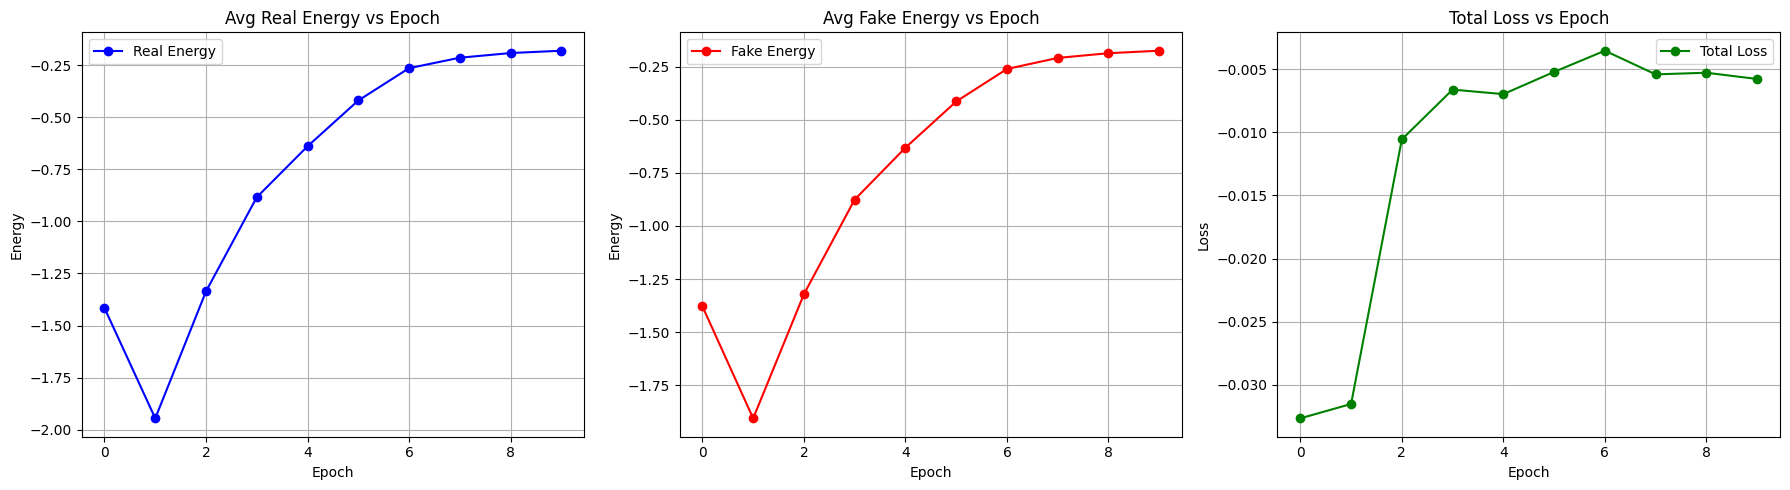

In [77]:
epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, epoch_real_energies, label='Real Energy', color='blue', marker='o')
plt.title('Avg Real Energy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, epoch_fake_energies, label='Fake Energy', color='red', marker='o')
plt.title('Avg Fake Energy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, epoch_losses, label='Total Loss', color='green', marker='o')
plt.title('Total Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Inference

# 1. Starting from training data and performing langevin sampling

each training data is treated as a real image therefore having a very low energy, so if the number of steps in langevin is too low (for example in the cell below is set to 20), then after sampling we'll see about the same image, **but** if we were to increase the number of cell (to for example 60), we can observe mode hopping. Increasing this number to 100 or 1000 will lead to only generating 1 (the model found this number has the lowest energy)

Langevin Steps = 60

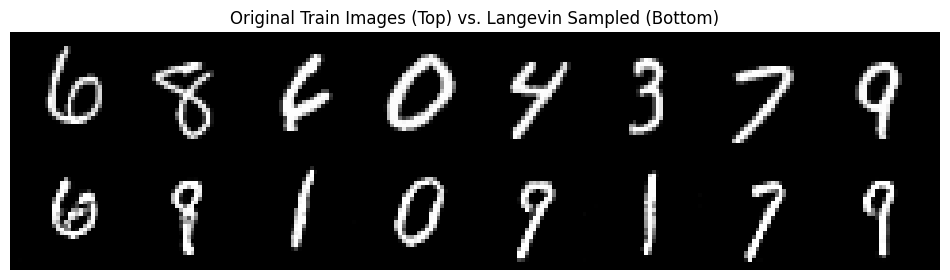

In [78]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = langevin_sampling(model, real_train_batch.clone(), steps=60, step_size=10.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

Langevin Steps = 20

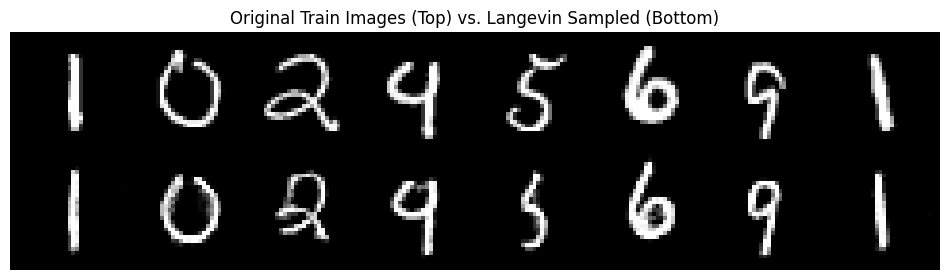

In [79]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = langevin_sampling(model, real_train_batch.clone(), steps=20, step_size=10.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

Langevin Steps = 50

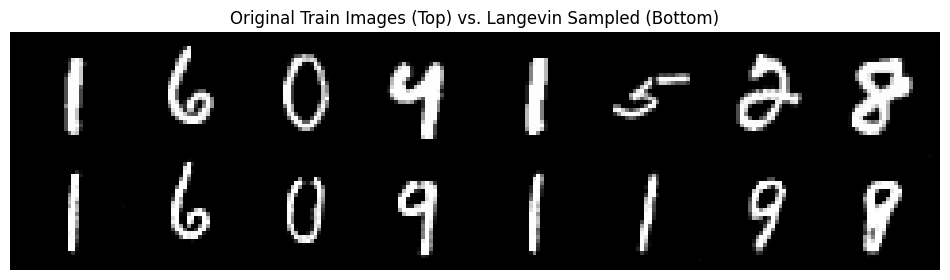

In [80]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = langevin_sampling(model, real_train_batch.clone(), steps=50, step_size=10.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

Langevin Steps = 100

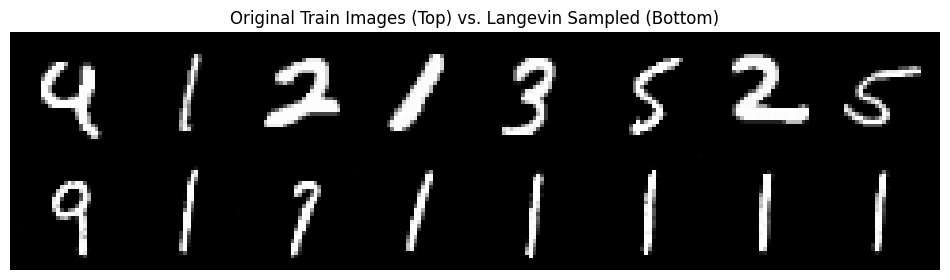

In [88]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = langevin_sampling(model, real_train_batch.clone(), steps=100, step_size=10.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

Langevin Steps = 1000

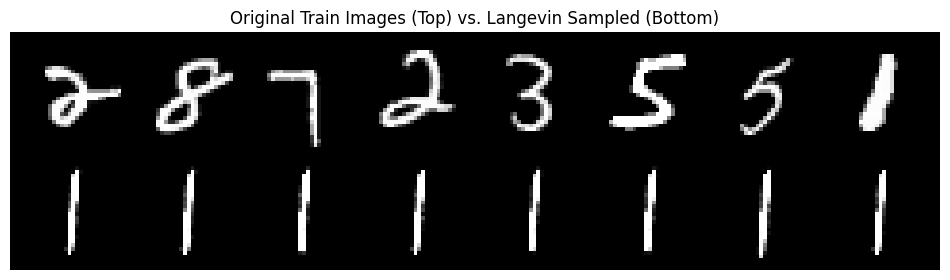

In [81]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = langevin_sampling(model, real_train_batch.clone(), steps=1000, step_size=100.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

# 2. Image Generation

starting with pure noise and then performing langevin sampling.

In the cells below, 20,60,100,200 and 300 langevin steps have been tested and the results show that regardless of the number steps

when starting from pure noise (random uniform noise) then it will generate 1. In the last part, we also saw this, the model found out that

1 has the lowest energy (probably because of it's the simplest digit to generate), and we can see mode collapse.

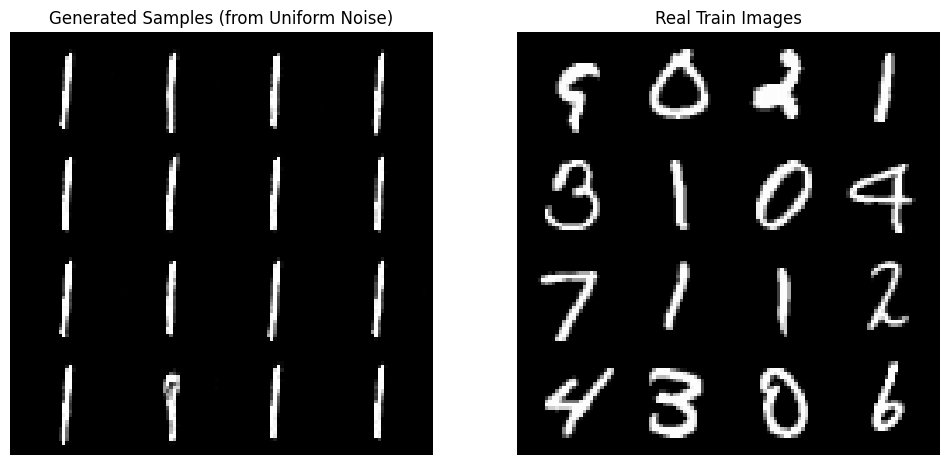

In [82]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = langevin_sampling(model, init_noise, steps=200, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

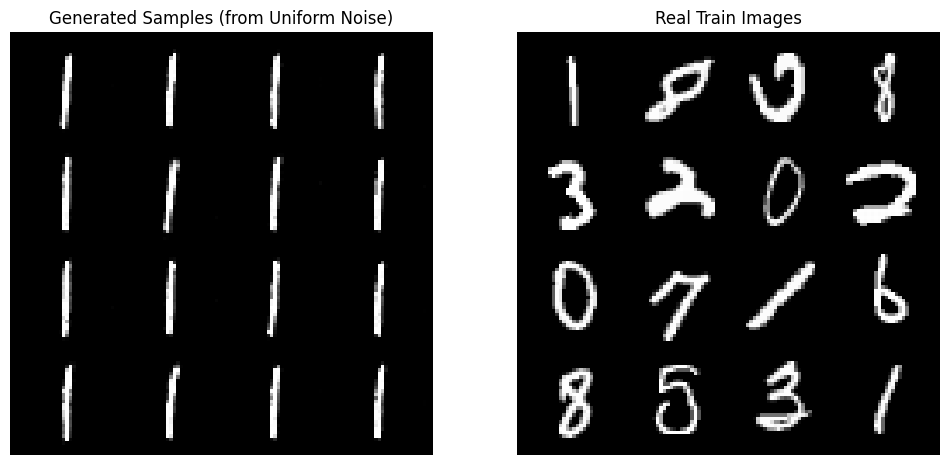

In [83]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = langevin_sampling(model, init_noise, steps=100, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

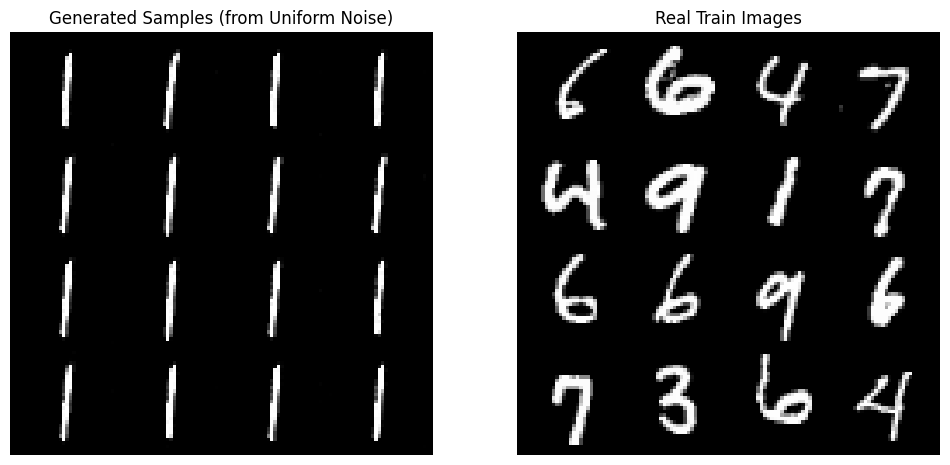

In [84]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = langevin_sampling(model, init_noise, steps=300, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

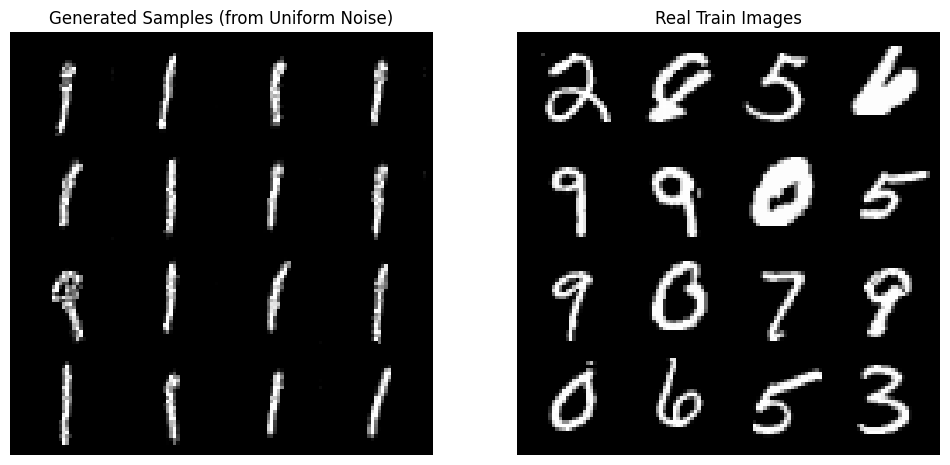

In [90]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = langevin_sampling(model, init_noise, steps=20, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    grid_real = torchvision.utils.make_grid(real, nrow=4)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

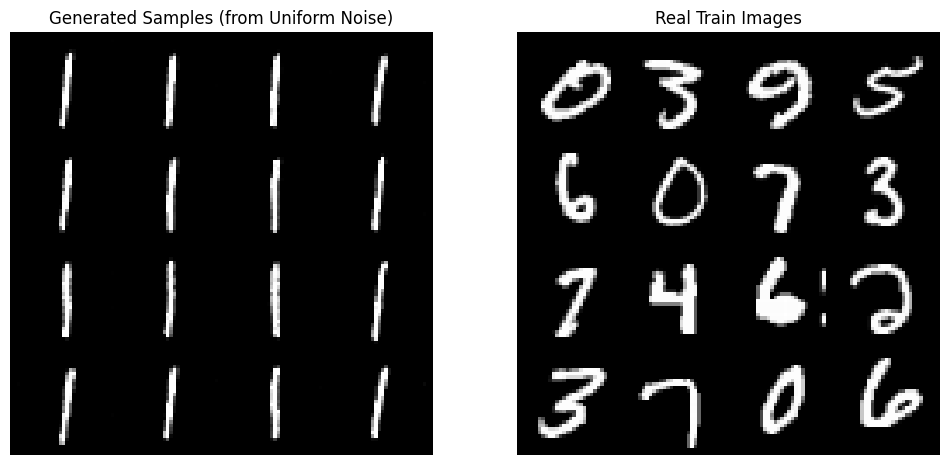

In [94]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = langevin_sampling(model, init_noise, steps=60, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    grid_real = torchvision.utils.make_grid(real, nrow=4)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

# 3. Denoising

The cells below are for 30,40,60 and 100 langevin steps.

Results for Noise Level (Sigma): 0.2


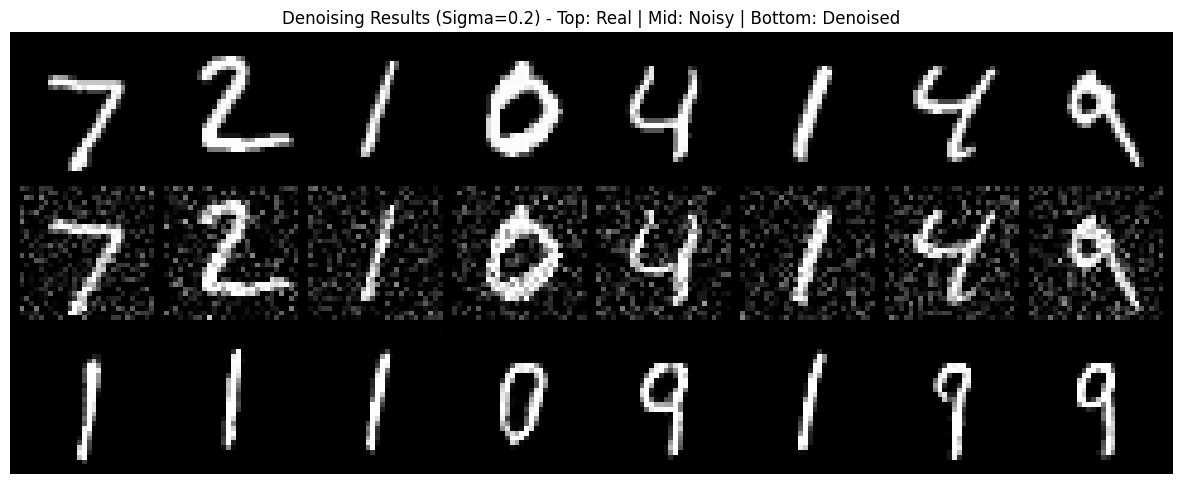

Results for Noise Level (Sigma): 0.4


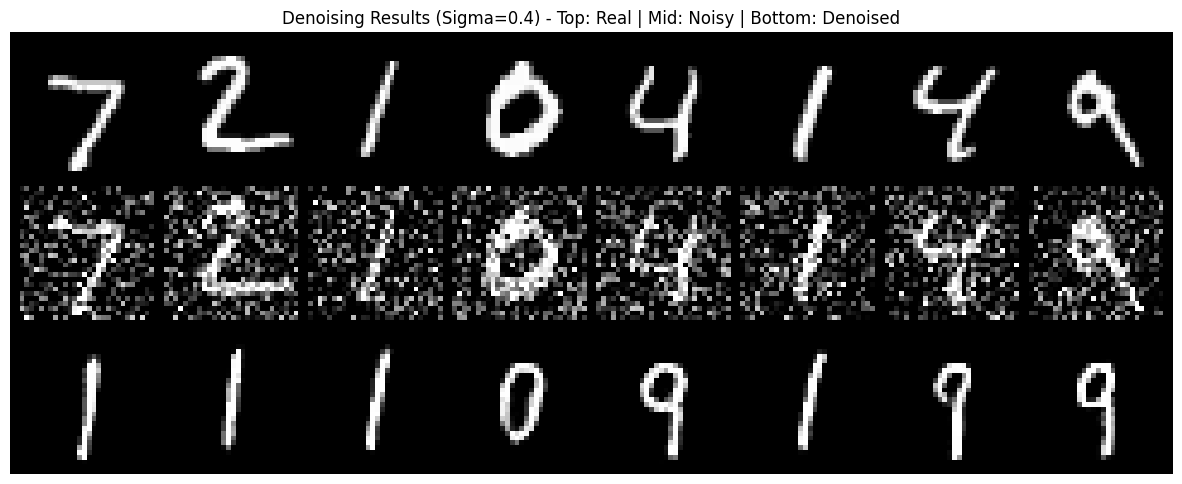

Results for Noise Level (Sigma): 0.6


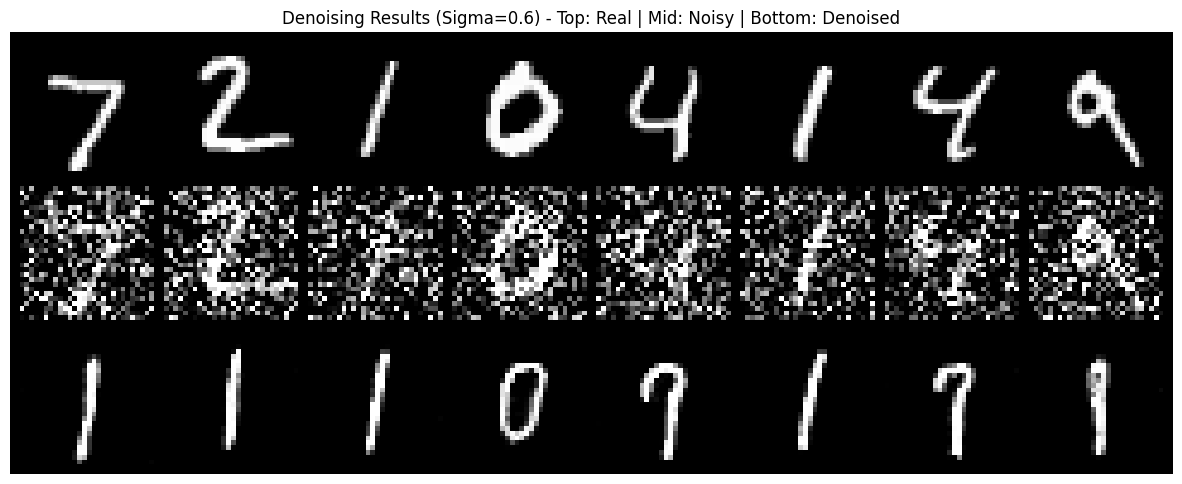

In [86]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, 0, 1)
    
    denoised_images = langevin_sampling(model, noisy_images.clone(), steps=100, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()

Results for Noise Level (Sigma): 0.2


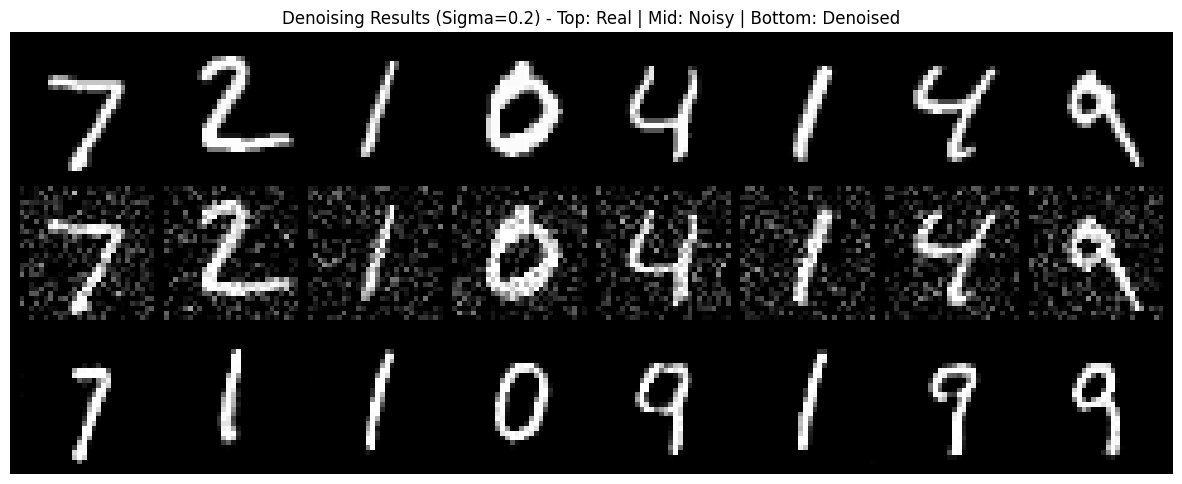

Results for Noise Level (Sigma): 0.4


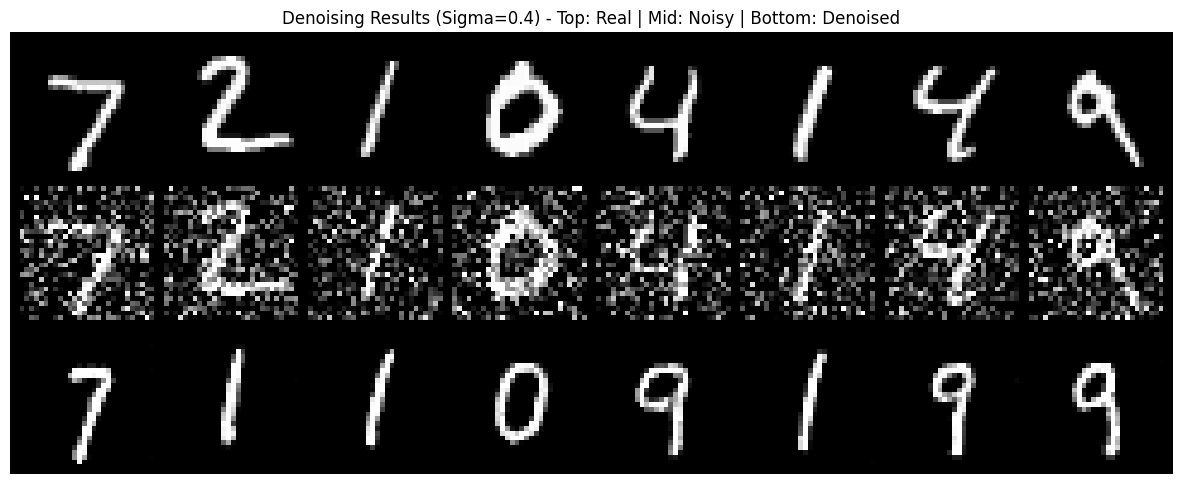

Results for Noise Level (Sigma): 0.6


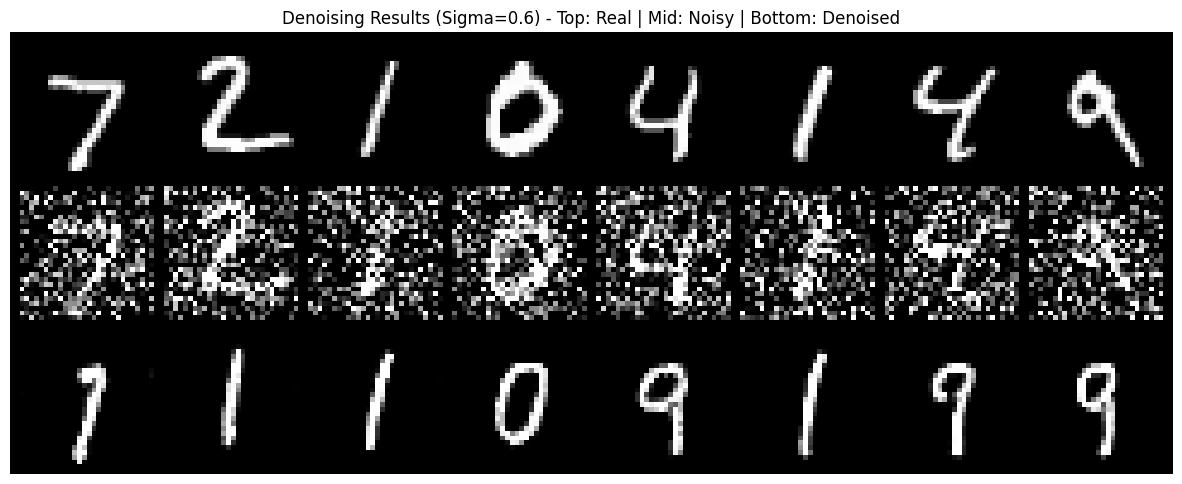

In [91]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, 0, 1)
    
    denoised_images = langevin_sampling(model, noisy_images.clone(), steps=60, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()

Results for Noise Level (Sigma): 0.2


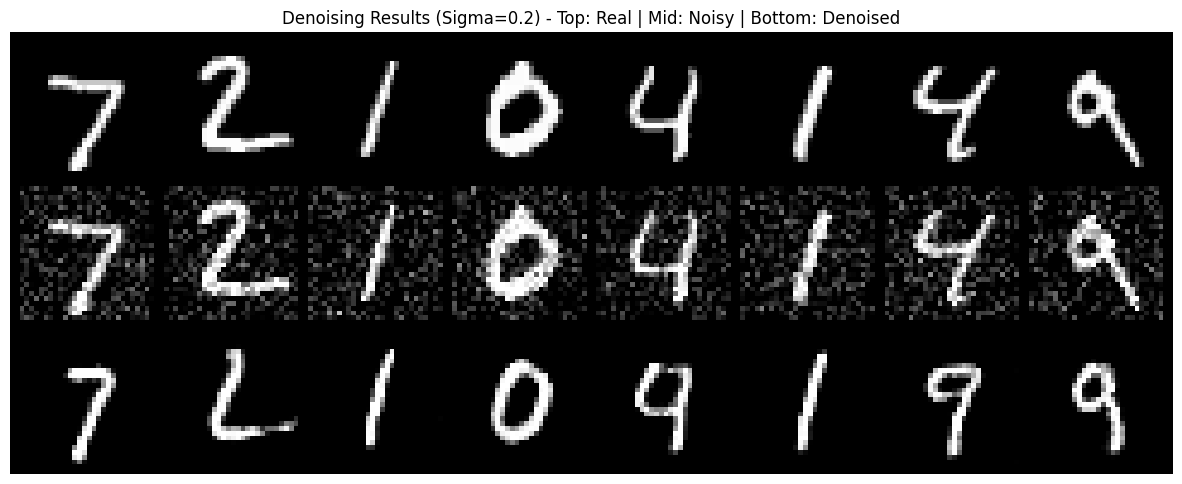

Results for Noise Level (Sigma): 0.4


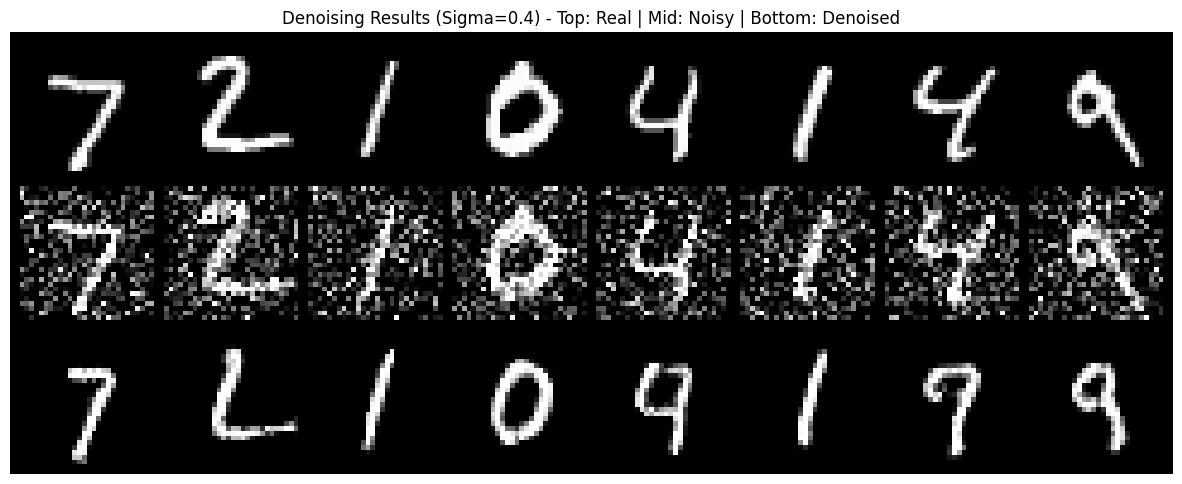

Results for Noise Level (Sigma): 0.6


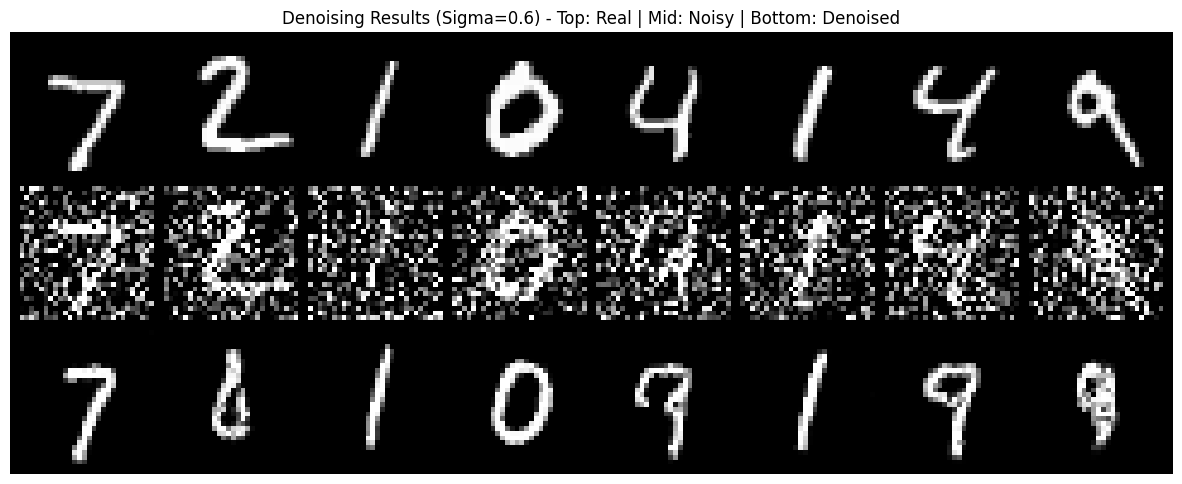

In [92]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, 0, 1)
    
    denoised_images = langevin_sampling(model, noisy_images.clone(), steps=30, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()

Results for Noise Level (Sigma): 0.2


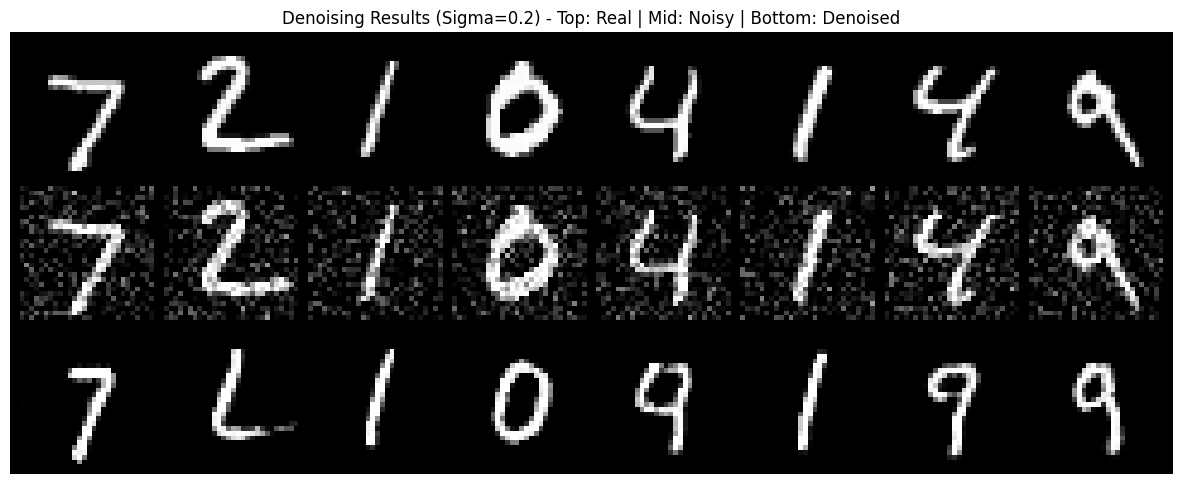

Results for Noise Level (Sigma): 0.4


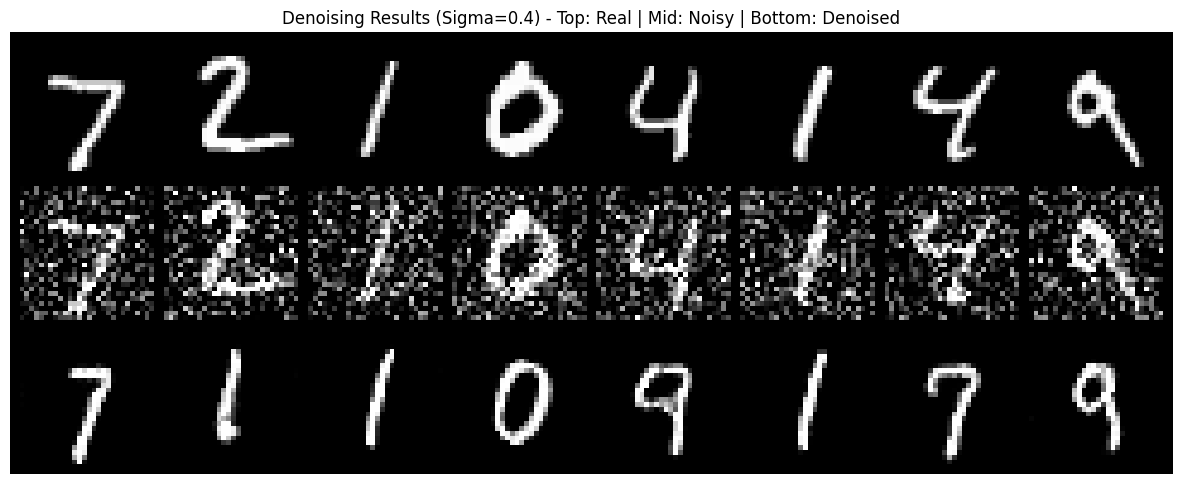

Results for Noise Level (Sigma): 0.6


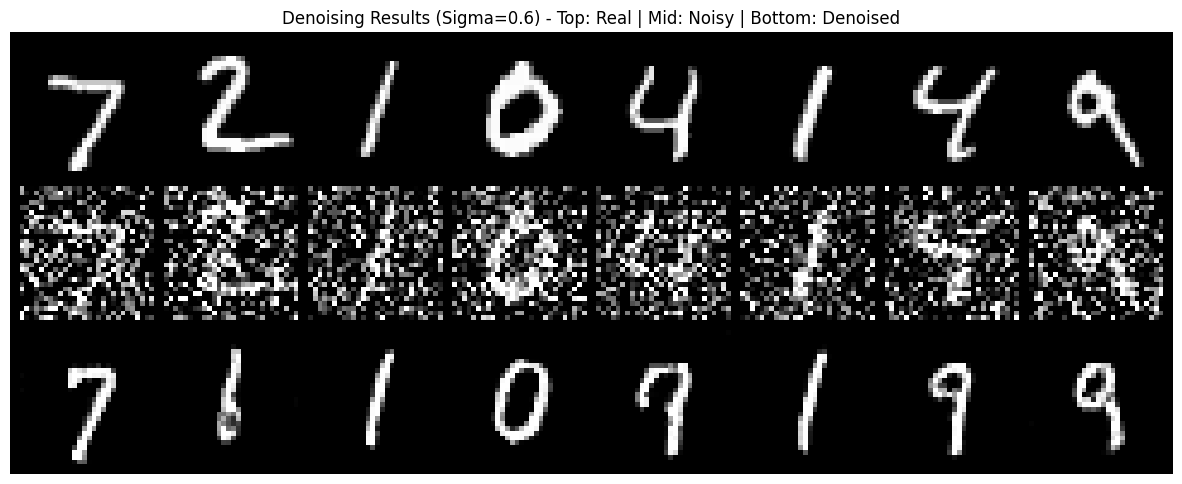

In [93]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, 0, 1)
    
    denoised_images = langevin_sampling(model, noisy_images.clone(), steps=40, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()